In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salesdata/Train.csv
/kaggle/input/salesdata/Test.csv


In [2]:
train = pd.read_csv("../input/salesdata/Train.csv")
test = pd.read_csv("../input/salesdata/Test.csv")

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
train.drop(['Item_Identifier'],axis=1,inplace=True)
test.drop(['Item_Identifier'],axis=1,inplace=True)

In [5]:
train.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [6]:
train.isna().sum()/len(train)*100

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [7]:
#test Data
test.isna().sum()/len(train)*100

Item_Weight                  11.451367
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  18.843130
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64

In [8]:
#filling Store Value train data
mode_outlet = train.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x: x.mode()[0]))
mode_outlet

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [9]:
#Missing Values
missing_outlet = train['Outlet_Size'].isnull()



In [10]:
train.loc[missing_outlet,'Outlet_Size'] = train.loc[missing_outlet,'Outlet_Type'].apply(lambda x: mode_outlet[x])

In [11]:
#filling Store Value train data
mode_outlet_test = test.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x: x.mode()[0]))
mode_outlet_test

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [12]:
missing_outlet_test = train['Outlet_Size'].isnull()
test.loc[missing_outlet_test,'Outlet_Size'] = test.loc[missing_outlet_test,'Outlet_Type'].apply(lambda x: mode_outlet_test[x])

In [13]:
#Filling Categorical train
for column in train.columns:
    if  train[column].dtype == object:
        train[column].fillna(train[column].mode()[0],inplace=True)

In [14]:
#Filling Numerical train:-
for column in train.columns:
    if  train[column].dtype == np.number:
        train[column].fillna(train[column].mean(),inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#Filling Numerical test:-
for column in test.columns:
    if  test[column].dtype == np.number:
        test[column].fillna(test[column].mean(),inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [18]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.replace('low fat','Low Fat')
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.replace('LF','Low Fat')
train['Item_Fat_Content'] = train['Item_Fat_Content'].str.replace('reg','Regular')


In [19]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [20]:
train.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


## Visualisation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `

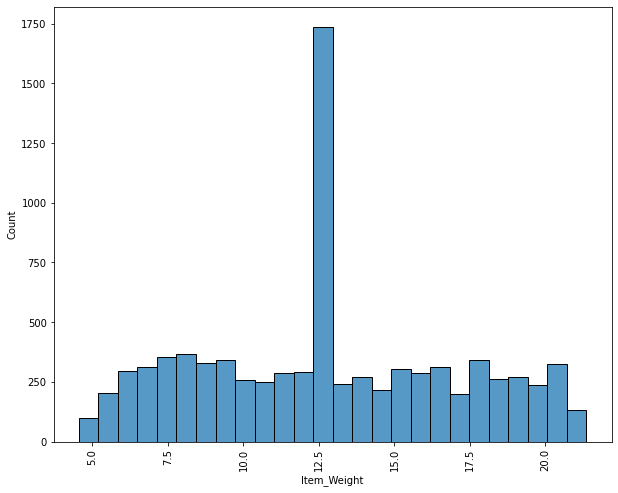

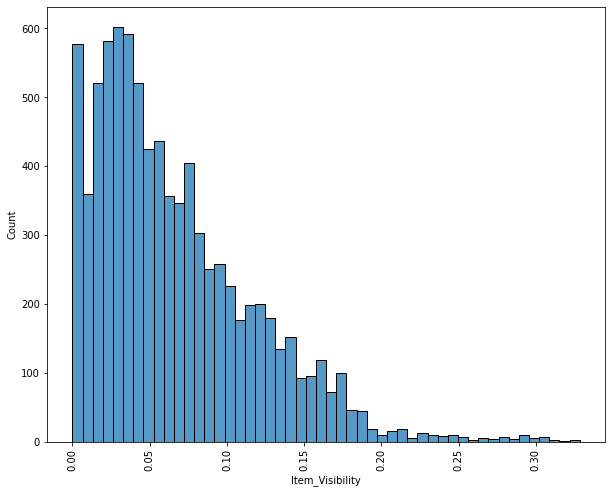

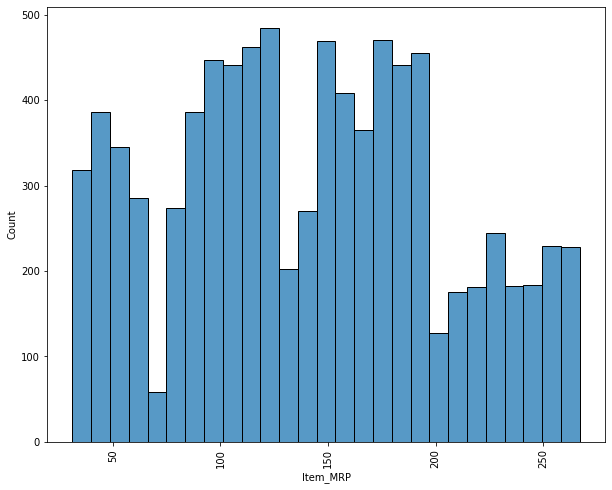

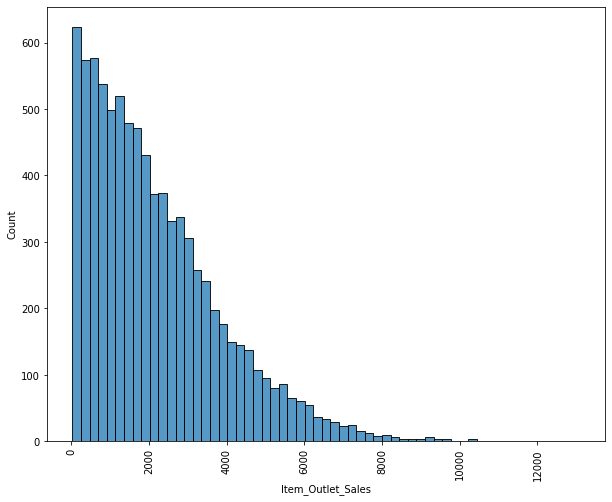

In [22]:
#Visualising Numerical Data
for i, column in enumerate(train.columns):
    if train[column].dtype == np.number:
        plt.figure(figsize=(10,8))
        sns.histplot(train[column])
        plt.xticks(rotation=90)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

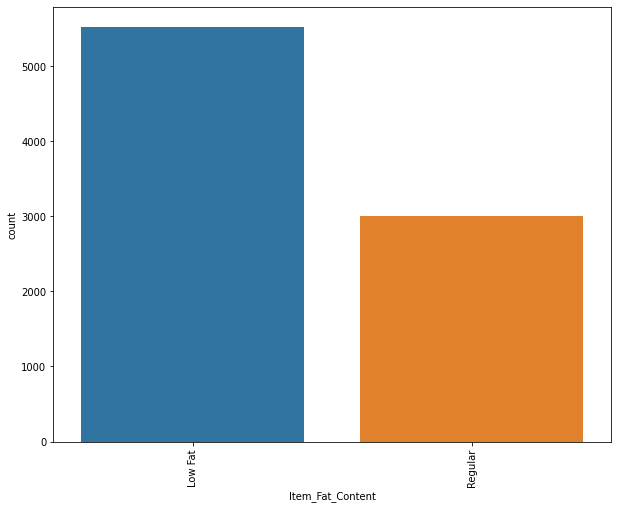

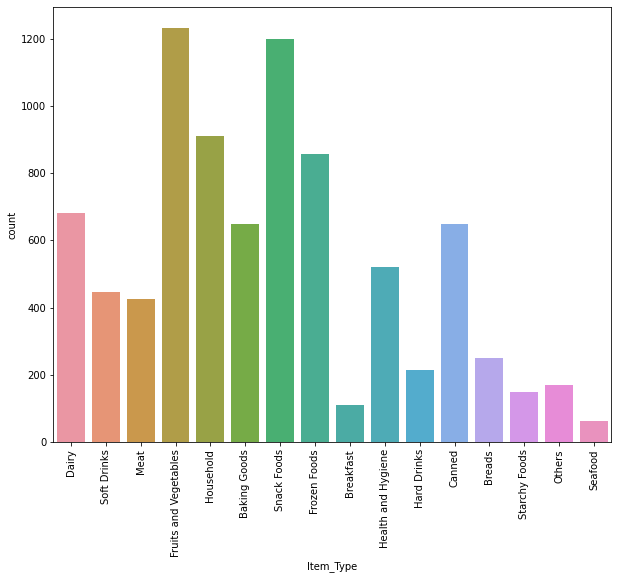

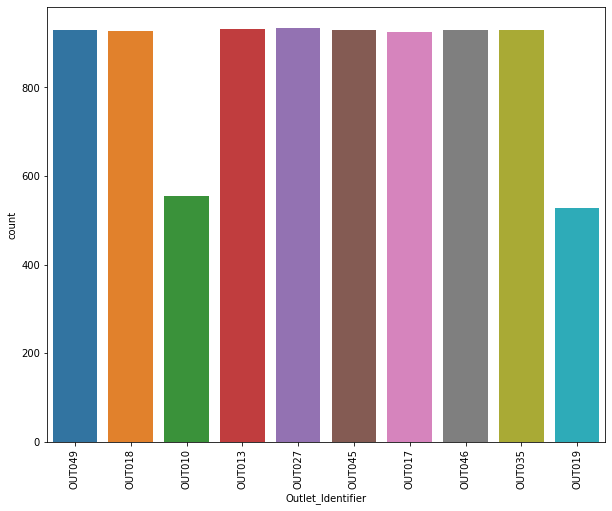

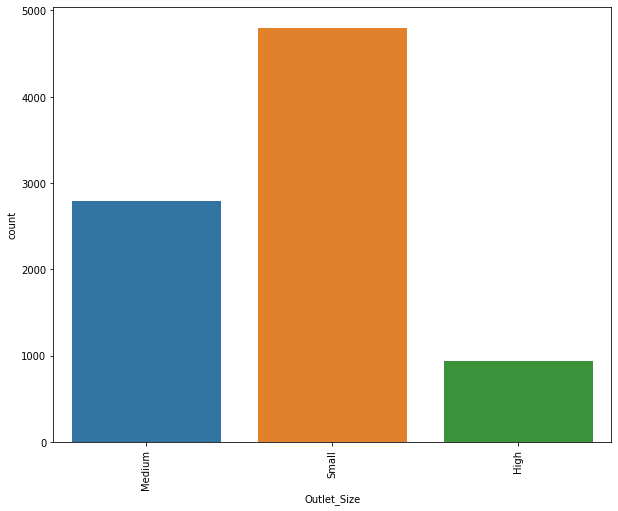

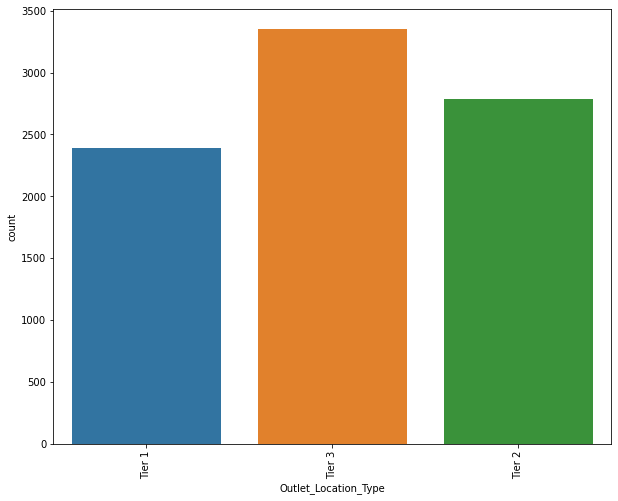

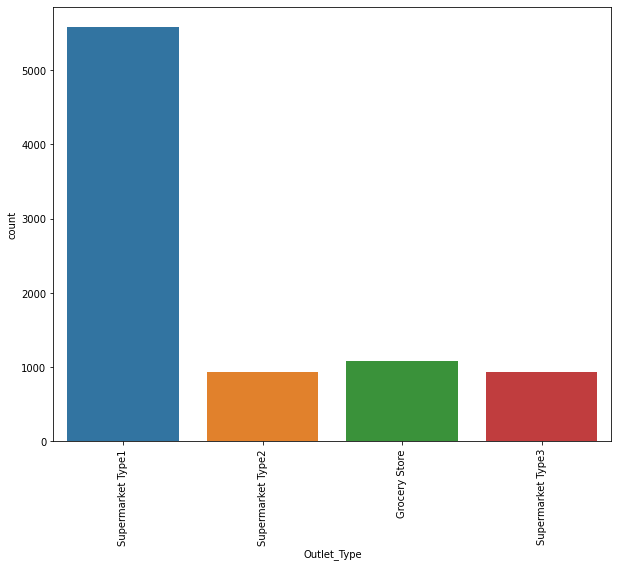

In [23]:
#Visualizing Categorical Data
for i, column in enumerate(train.columns):
    if train[column].dtype == object:
        plt.figure(figsize=(10,8))
        sns.countplot(train[column])
        plt.xticks(rotation=90)


## Label Encoding

In [24]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [25]:
for column in train.columns:
    if train[column].dtype == object:
        train[column] = encoder.fit_transform(train[column])
        
    

In [26]:
for column in test.columns:
    if test[column].dtype == object:
        test[column] = encoder.fit_transform(test[column])
        
    

## Splitting Features & Target

In [27]:
X = train.drop(columns='Item_Outlet_Sales',axis=1)
Y = train['Item_Outlet_Sales'] 

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

## ML MODEL

In [30]:
regressor = XGBRegressor()
regressor.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Evaluation

In [31]:
#Prediction on Training data
training_data_prediction = regressor.predict(x_train)

In [32]:
#R Square error
r2_train = metrics.r2_score(y_train,training_data_prediction)

In [33]:
print("R Squared Value = ",r2_train*100)

R Squared Value =  84.9989620732928


In [34]:
#Prediction on Test Data
prediction = regressor.predict(test)


In [35]:
# Creating DataFrame
raw_data = pd.read_csv("../input/salesdata/Test.csv")
submission = pd.DataFrame({"Item_Identifier":raw_data.Item_Identifier,'Item_Outlet_Sales':prediction})


In [36]:
submission.to_csv("Submission.csv",index=False)